#Загрузка необходимых библиотек

In [89]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pyspark.sql import SparkSession
from datetime import datetime 
import math
import seaborn as sns

#Загрузка данных, чистка массива

In [90]:
DF = pd.read_csv('top_10000_1960-now.csv', delimiter=',')

In [91]:
DF.isnull().sum()

Track URI                  0
Track Name                 1
Artist URI(s)              2
Artist Name(s)             1
Album URI                  2
Album Name                 1
Album Artist URI(s)        2
Album Artist Name(s)       2
Album Release Date         2
Album Image URL            4
Disc Number                0
Track Number               0
Track Duration (ms)        0
Track Preview URL       2897
Explicit                   0
Popularity                 0
ISRC                       3
Added By                   0
Added At                   0
Artist Genres            550
Danceability               2
Energy                     2
Key                        2
Loudness                   2
Mode                       2
Speechiness                2
Acousticness               2
Instrumentalness           2
Liveness                   2
Valence                    2
Tempo                      2
Time Signature             2
Album Genres            9999
Label                      6
Copyrights    

In [92]:
del DF['Album Genres']
del DF['Track Preview URL']

In [93]:
DF1 = DF.dropna()
DF1.shape

(9429, 33)

#Пункт №1. Вывод средних значений по декадам

In [94]:
def Periods_Make(Dataset, Column_date):
    DF = Dataset.sort_values(Column_date)
    DF[Column_date] = pd.to_datetime(DF[Column_date])

    end_of_decades = []
    start_of_decades = []

    for i in range(0, len(DF)):
        end_year = DF[Column_date].dt.year.iloc[i] % 10
        if end_year == 0:
            if DF[Column_date].dt.year.iloc[i] not in end_of_decades:
                end_of_decades.append(DF[Column_date].dt.year.iloc[i])

    start_of_decades = [DF[Column_date].dt.year.iloc[0]]
    for i in range(0, len(DF)):
        if DF[Column_date].dt.year.iloc[i] % 10 == 1:
            if DF[Column_date].dt.year.iloc[i] not in start_of_decades:
                start_of_decades.append(DF[Column_date].dt.year.iloc[i])
    start_of_decades.append(DF[Column_date].dt.year.iloc[-1])

    mean_dance_decades = {}
    start = []
    end = []
    for i in range(0, len(start_of_decades)):
        if i == len(start_of_decades) - 2:
            mean_dance_decades[str(start_of_decades[-2]) + ' - ' + str(start_of_decades[-1])] = 0
            start.append(start_of_decades[-2])
            end.append(start_of_decades[-1])
        elif i == len(start_of_decades) - 1:
            break
        else:
            mean_dance_decades[str(start_of_decades[i]) + ' - ' + str(round(start_of_decades[i] + 5, -1))] = 0
            start.append(start_of_decades[i])
            end.append(round(start_of_decades[i] + 5, -1))
    return start, end

In [95]:
def Features(Dataset, Column_dt, Column_dn, start_period, end_period):
    Dataset = Dataset.sort_values(Column_dt)
    Dataset[Column_dt] = pd.to_datetime(Dataset[Column_dt])
    mean_values = []
    period = []
    for j in range(0, len(start_period)):
        DF_draft = Dataset[[Column_dt, Column_dn]].loc[(Dataset[Column_dt].dt.year < end_period[j]) & \
                                                       (Dataset[Column_dt].dt.year >= start_period[j])]
        mean_value = DF_draft[Column_dn].sum() / len(DF_draft)
        mean_values.append(mean_value)
        period.append(str(start_period[j]) + '-' + str(end_period[j]))
    DF = pd.DataFrame(list(zip(period, mean_values)), columns=['Period', 'Mean '+ str(Column_dn)])
    return DF

In [96]:
period_start_end = Periods_Make(DF1, 'Album Release Date')

In [97]:
dance = Features(DF1, 'Album Release Date', 'Danceability', period_start_end[0], period_start_end[1])
energy = Features(DF1, 'Album Release Date', 'Energy', period_start_end[0], period_start_end[1])
acoustic = Features(DF1, 'Album Release Date', 'Acousticness', period_start_end[0], period_start_end[1])
instrumental = Features(DF1, 'Album Release Date', 'Instrumentalness', period_start_end[0], period_start_end[1])
loud = Features(DF1, 'Album Release Date', 'Loudness', period_start_end[0], period_start_end[1])
duration = Features(DF1, 'Album Release Date', 'Track Duration (ms)', period_start_end[0], period_start_end[1])

C:\Users\Глеб\AppData\Local\Temp\ipykernel_4856\2894816351.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  dance.set_xticklabels(dance.get_xticklabels(), rotation=30)
C:\Users\Глеб\AppData\Local\Temp\ipykernel_4856\2894816351.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  energy.set_xticklabels(energy.get_xticklabels(), rotation=30)
C:\Users\Глеб\AppData\Local\Temp\ipykernel_4856\2894816351.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  acoustic.set_xticklabels(acoustic.get_xticklabels(), rotation=30)
C:\Users\Глеб\AppData\Local\Temp\ipykernel_4856\2894816351.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  instrumental.set_xticklabels(instrumental.get_xticklabels(), rotation=30)


[Text(0, 0, '1956-1960'),
 Text(1, 0, '1961-1970'),
 Text(2, 0, '1971-1980'),
 Text(3, 0, '1981-1990'),
 Text(4, 0, '1991-2000'),
 Text(5, 0, '2001-2010'),
 Text(6, 0, '2011-2020'),
 Text(7, 0, '2021-2023')]

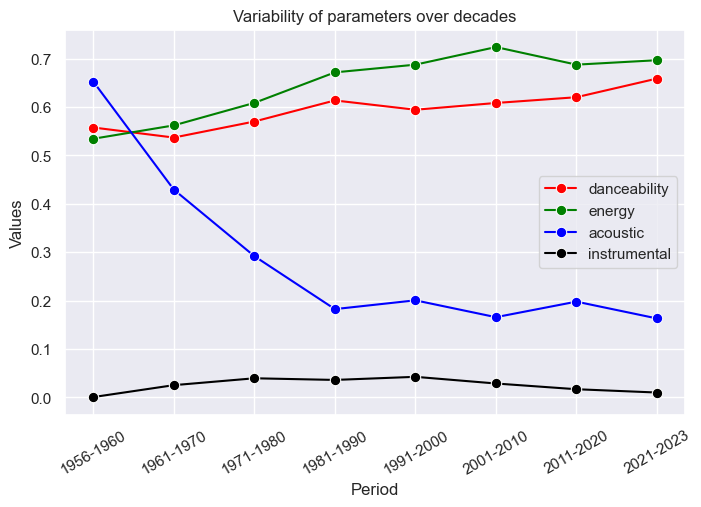

In [98]:
sns.set(rc={'figure.figsize':(8,5)})
plt.xlabel('Period')
plt.ylabel('Values')
plt.title('Variability of parameters over decades')

dance = sns.lineplot(data=dance, x='Period', y='Mean Danceability', color='red', label='danceability', marker='.', markersize='15')
dance.set_xticklabels(dance.get_xticklabels(), rotation=30)

energy = sns.lineplot(data=energy, x='Period', y='Mean Energy', color='green', label='energy', marker='.', markersize='15')
energy.set_xticklabels(energy.get_xticklabels(), rotation=30)

acoustic = sns.lineplot(data=acoustic, x='Period', y='Mean Acousticness', color='blue', label='acoustic', marker='.', markersize='15')
acoustic.set_xticklabels(acoustic.get_xticklabels(), rotation=30)

instrumental = sns.lineplot(data=instrumental, x='Period', y='Mean Instrumentalness', color='black', label='instrumental', marker='.', markersize='15')
instrumental.set_xticklabels(instrumental.get_xticklabels(), rotation=30)

#loud = sns.lineplot(data=loud, x='Period', y='Mean Loudness')
#loud.set_xticklabels(loud.get_xticklabels(), rotation=30)

In [99]:
# Как можно заметить, на графиках демонстрируется спад акустичности и инструментальности песен с течением времени с 1956 по нынешний год.
# У людей растет потребность в простоте песен. Это подкреплено ростом уровня энергичности и танцевальности песен. Таким образом, все больше
# выпускается электронная музыка, без использования в записи чистого инструментального звучания.  

#Пункт №2. Топ 3 жанров по периодам в 10 лет

In [100]:
def top_genres(Dataset, Sort_column, Column_genre, start_period, end_period):
    Dataset = Dataset.sort_values(Sort_column)
    Dataset[Sort_column] = pd.to_datetime(Dataset[Sort_column])

    DF_draft = Dataset.loc[(Dataset[Sort_column].dt.year < end_period) & \
                            (Dataset[Sort_column].dt.year >= start_period)]
    genres = []
    for i in range(0, len(DF_draft)):
        genre = DF_draft[Column_genre].iloc[i].split(',')
        for j in range(0, len(genre)):
            if genre[j] not in genres:
                genres.append(genre[j])
    
    genres_dict = {}
    for i in range(0, len(genres)):
        genres_dict[str(genres[i])] = 0

    for i in range(0, len(DF_draft)):
        g = DF_draft[Column_genre].iloc[i].split(',')
        for j in range(0, len(g)):
            genres_dict[g[j]] += 1

    d = dict(reversed(sorted(genres_dict.items(), key=lambda k:(k[1]))))
    genre_df = pd.DataFrame(d.items(), columns=['genre', 'number'])
    periods = []
    for i in range(0, genre_df.shape[0]):
        period = str(start_period) + '-' + str(end_period)
        periods.append(period)
    genre_df['period'] = periods
    res = genre_df.head(3)

    return res
        

In [101]:
Top0 = top_genres(DF1, 'Album Release Date', 'Artist Genres', period_start_end[0][0], period_start_end[1][0])
Top1 = top_genres(DF1, 'Album Release Date', 'Artist Genres', period_start_end[0][1], period_start_end[1][1])
Top2 = top_genres(DF1, 'Album Release Date', 'Artist Genres', period_start_end[0][2], period_start_end[1][2])
Top3 = top_genres(DF1, 'Album Release Date', 'Artist Genres', period_start_end[0][3], period_start_end[1][3])
Top4 = top_genres(DF1, 'Album Release Date', 'Artist Genres', period_start_end[0][4], period_start_end[1][4])
Top5 = top_genres(DF1, 'Album Release Date', 'Artist Genres', period_start_end[0][5], period_start_end[1][5])
Top6 = top_genres(DF1, 'Album Release Date', 'Artist Genres', period_start_end[0][6], period_start_end[1][6])
Top7 = top_genres(DF1, 'Album Release Date', 'Artist Genres', period_start_end[0][7], period_start_end[1][7])

In [102]:
AllTop = pd.DataFrame({'genre':[], 'number':[], 'period':[]})
for i in range(0, len(period_start_end[0])):   
    df = top_genres(DF1, 'Album Release Date', 'Artist Genres', period_start_end[0][i], period_start_end[1][i])
    AllTop = AllTop.append(df)
Top = AllTop.sort_values(['period','number'], ascending=False)

C:\Users\Глеб\AppData\Local\Temp\ipykernel_4856\2378383620.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  AllTop = AllTop.append(df)
C:\Users\Глеб\AppData\Local\Temp\ipykernel_4856\2378383620.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  AllTop = AllTop.append(df)
C:\Users\Глеб\AppData\Local\Temp\ipykernel_4856\2378383620.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  AllTop = AllTop.append(df)
C:\Users\Глеб\AppData\Local\Temp\ipykernel_4856\2378383620.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  AllTop = AllTop.append(df)
C:\Users\Глеб\AppData\Local\Temp\ipykernel_4856\2378383620.py:4: FutureWarning: The frame.ap

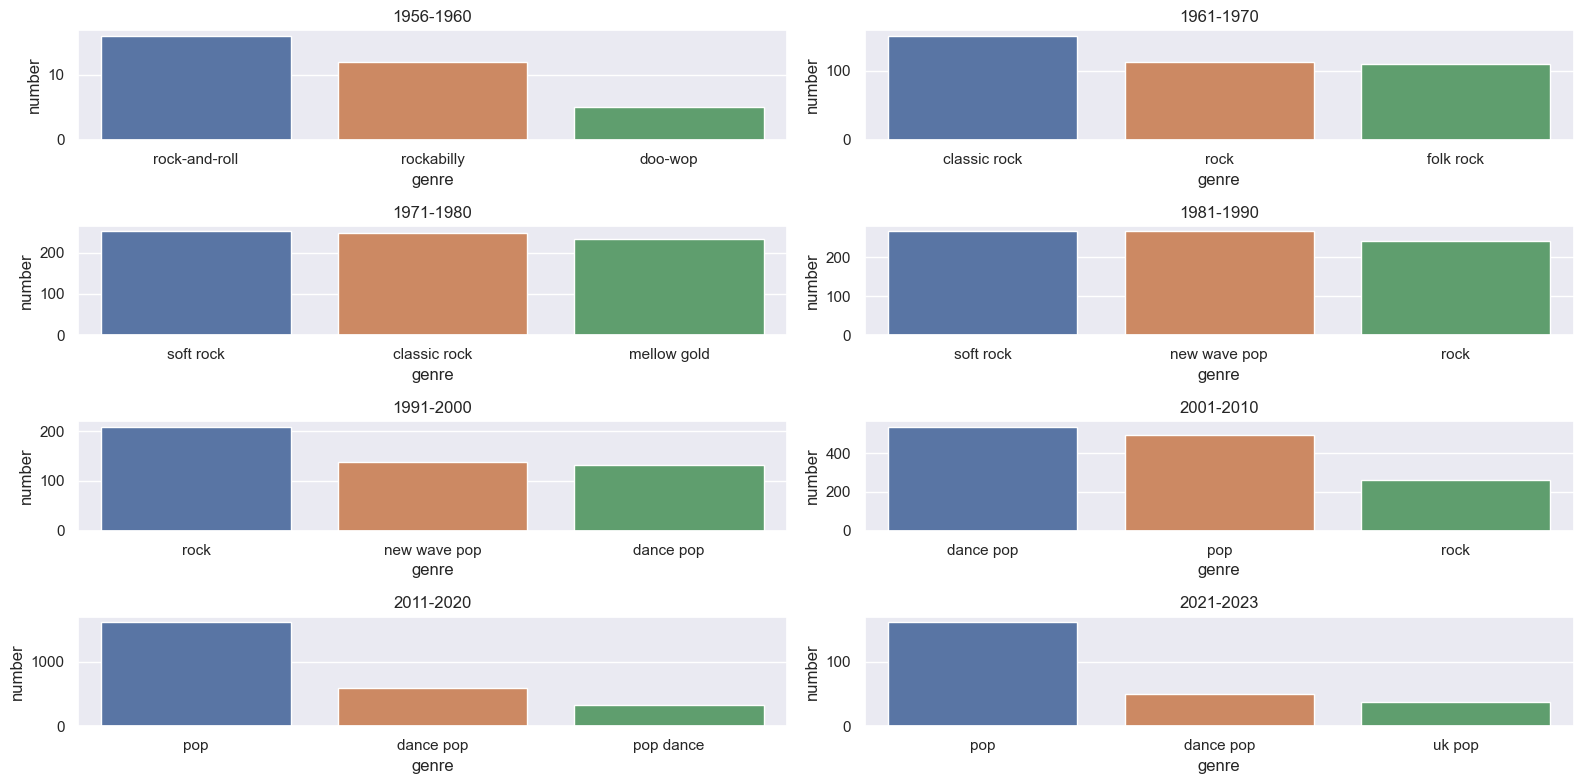

In [103]:
fig, axes = plt.subplots(4, 2, sharex=False, figsize=(16,8))
sns.barplot(ax=axes[0, 0], data=Top0, x='genre', y='number')
ax = axes[0, 0].set_title("1956-1960")
sns.barplot(ax=axes[0, 1], data=Top1, x='genre', y='number')
ax = axes[0, 1].set_title("1961-1970")
sns.barplot(ax=axes[1, 0], data=Top2, x='genre', y='number')
ax = axes[1, 0].set_title("1971-1980")
sns.barplot(ax=axes[1, 1], data=Top3, x='genre', y='number')
ax = axes[1, 1].set_title("1981-1990")
sns.barplot(ax=axes[2, 0], data=Top4, x='genre', y='number')
ax = axes[2, 0].set_title("1991-2000")
sns.barplot(ax=axes[2, 1], data=Top5, x='genre', y='number')
ax = axes[2, 1].set_title("2001-2010")
sns.barplot(ax=axes[3, 0], data=Top6, x='genre', y='number')
ax = axes[3, 0].set_title("2011-2020")
sns.barplot(ax=axes[3, 1], data=Top7, x='genre', y='number')
ax = axes[3, 1].set_title("2021-2023")
plt.tight_layout()


In [104]:
# С 1960-ых по 2000-ые годы рок музыка пользовалась существенным спросом и находилась в топе 3 каждое 10-летие. 
# Однако с приближением текущего времени рок-жанр стала затмевать поп-музыка. Это также подтверждается соответствующим
# изменением показателей параметров песен в предыдущем пункте. 

#Пункт №3. Вывод лучших жанров по годам

In [105]:
def top_genre_by_year(Dataset, Column_dt, Column_genre):
    
    Dataset = Dataset.sort_values(Column_dt)
    Dataset[Column_dt] = pd.to_datetime(Dataset[Column_dt])
    
    years = []

    for i in range(0, len(Dataset)):
        if Dataset[Column_dt].dt.year.iloc[i] not in years:
            years.append(Dataset[Column_dt].dt.year.iloc[i])

    top_genre_year = {}
    for i in range(0, len(years)):
        top_genre_year[str(years[i])] = 0

    for k in range(0, len(years)):

        DF_draft = Dataset.loc[Dataset[Column_dt].dt.year == years[k]]

        genre = []
        for i in range(0, len(DF_draft)):
            genres = DF_draft[Column_genre].iloc[i].split(',')
            for j in range(0, len(genres)):     
                if genres[j] not in genre:
                    genre.append(genres[j])

        genree_dict = {}
        for i in range(0, len(genre)):
            genree_dict[str(genre[i])] = 0

        for i in range(0, len(DF_draft)):
            genree = DF_draft[Column_genre].iloc[i].split(',')
            for j in range(0, len(genree)):
                genree_dict[genree[j]] += 1
        dic_gen = dict(reversed(sorted(genree_dict.items(), key=lambda k:(k[1]))))
    
        top_genre_year[str(years[k])] = list(dic_gen.keys())[0]
    
    return top_genre_year

In [106]:
Top_Genre = top_genre_by_year(DF1, 'Album Release Date', 'Artist Genres')
Df_genre = pd.DataFrame(Top_Genre.items(), columns=['year', 'best genre'])
Df_genre

,year,best genre
0,1956,rockabilly
1,1958,rock-and-roll
2,1959,rock-and-roll
3,1960,soul
4,1961,rock-and-roll
...,...,...
62,2019,pop
63,2020,pop
64,2021,pop
65,2022,pop


In [107]:
# В очередной раз доказывается то, что поп-музыка лидирует на мировой сцене как минимум последние 5 лет

#Пункт №4. Количество песен по лейблам

In [108]:
Df_label = DF1.groupby('Label')['Track Name'].count().to_frame('number songs').reset_index().sort_values('number songs', ascending=False).head(10)

C:\Users\Глеб\AppData\Local\Temp\ipykernel_4856\1439955473.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=0)


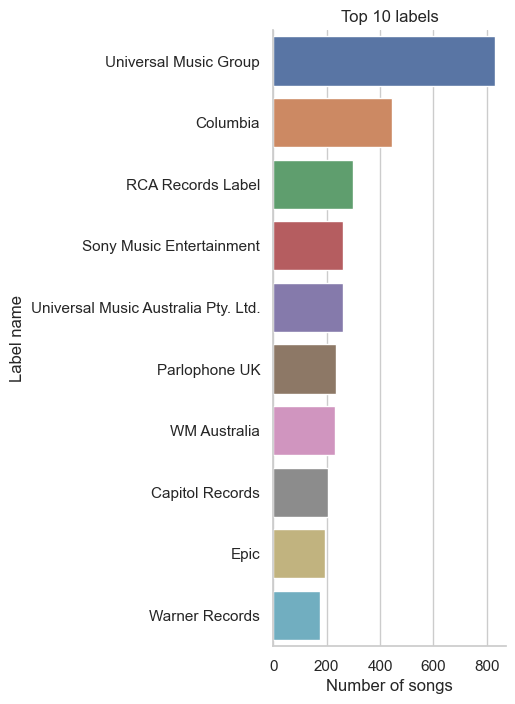

In [109]:
sns.set(style='whitegrid', rc={'figure.figsize':(3,8)})
ax = sns.barplot(data = Df_label, x = 'number songs', y = 'Label')
ax.set_title('Top 10 labels')
ax.set_xlabel('Number of songs')
ax.set_ylabel('Label name')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
sns.despine()

In [110]:
# На диаграмме выше представлен Топ-10 лейблов по количеству выпускаемых треков. С существенным отрывом лидирует
# компания Universal Music Group 

#Пункт №5. Топ 10 треков по критерию популярности.

In [111]:
Df_popular = DF1.sort_values('Popularity', ascending=False)
Df_popular[['Track Name', 'Artist Name(s)', 'Album Release Date', 'Popularity', 'Artist Genres']].head(10)

,Track Name,Artist Name(s),Album Release Date,Popularity,Artist Genres
2428,vampire,Olivia Rodrigo,2023-06-30,98,pop
9077,Cupid - Twin Ver.,FIFTY FIFTY,2023-02-24,97,k-pop girl group
213,Flowers,Miley Cyrus,2023-01-13,96,pop
2083,Anti-Hero,Taylor Swift,2022-10-21,95,pop
1586,Creepin' (with The Weeknd & 21 Savage),"Metro Boomin, The Weeknd, 21 Savage",2022-12-02,95,"hip hop,rap,canadian contemporary r&b,canadian..."
1224,I Ain't Worried,OneRepublic,2022-05-13,95,"piano rock,pop"
9039,I'm Good (Blue),"David Guetta, Bebe Rexha",2022-08-26,95,"big room,dance pop,edm,pop,pop dance,dance pop..."
2686,Dance The Night (From Barbie The Album),Dua Lipa,2023-05-25,95,"dance pop,pop,uk pop"
7430,Calm Down (with Selena Gomez),"Rema, Selena Gomez",2022-08-25,94,"afrobeats,nigerian pop,pop,post-teen pop"
4479,Starboy,"The Weeknd, Daft Punk",2016-11-25,94,"canadian contemporary r&b,canadian pop,pop,ele..."


In [112]:
def Part_of_total(Dataset, Column_popular, start_interval, end_interval, output):
    DF = Dataset.loc[(Dataset[Column_popular] <= end_interval) & (Dataset[Column_popular] >= start_interval)]
    part = round((DF.shape[0] * 100 / Dataset.shape[0]), 2)
    if output == 'DataFrame':
        return DF
    elif output == 'Part':
        return print('Part of songs with popularity between', start_interval, ' and ', end_interval, ' is ', part)
    elif output == 'Num':
        return part

In [113]:
Part_0_40 = Part_of_total(DF1, 'Popularity', 0, 40, 'Num')
Part_40_70 = Part_of_total(DF1, 'Popularity', 40, 70, 'Num')
Part_70_100 = Part_of_total(DF1, 'Popularity', 70, 100, 'Num')

In [114]:
Part_70_100

18.18

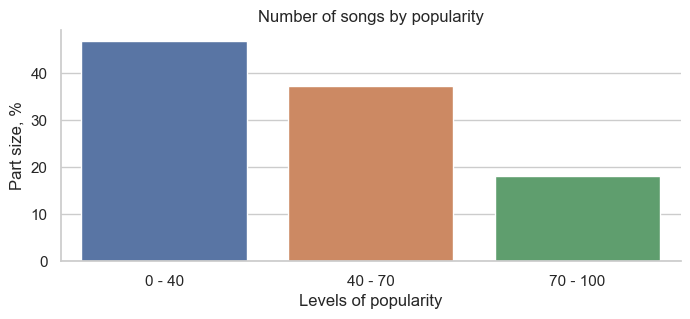

In [115]:
d_part = {'0 - 40': Part_0_40, '40 - 70': Part_40_70, '70 - 100': Part_70_100}
df_parts = pd.DataFrame(d_part.items(), columns=['part', 'percentage'])
sns.set(style='whitegrid', rc={'figure.figsize':(8,3)})
sns.barplot(data=df_parts, x=df_parts['part'], y=df_parts['percentage'])
plt.title('Number of songs by popularity')
plt.xlabel('Levels of popularity')
plt.ylabel('Part size, %')
sns.despine()


In [116]:
DF_0_40 = Part_of_total(DF1, 'Popularity', 0, 40, 'DataFrame')
DF_0_40['Album Release Date'] = pd.to_datetime(DF_0_40['Album Release Date'])
years_0_40 = DF_0_40.groupby(DF_0_40['Album Release Date'].dt.year)['Track Name', 'Popularity'].agg({'Track Name':'count', 'Popularity':'mean'}).\
    round(2).reset_index().rename(columns={'Track Name': 'Number of songs', 'Popularity':'Avg popularity'}).\
        sort_values('Number of songs', ascending=False)
years_0_40.head(5)

C:\Users\Глеб\AppData\Local\Temp\ipykernel_4856\541141214.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DF_0_40['Album Release Date'] = pd.to_datetime(DF_0_40['Album Release Date'])
C:\Users\Глеб\AppData\Local\Temp\ipykernel_4856\541141214.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  years_0_40 = DF_0_40.groupby(DF_0_40['Album Release Date'].dt.year)['Track Name', 'Popularity'].agg({'Track Name':'count', 'Popularity':'mean'}).\


,Album Release Date,Number of songs,Avg popularity
51,2009,226,11.23
56,2014,222,10.44
57,2015,209,8.20
58,2016,202,9.60
53,2011,198,9.26


In [117]:
DF_40_70 = Part_of_total(DF1, 'Popularity', 40, 70, 'DataFrame')
DF_40_70['Album Release Date'] = pd.to_datetime(DF_40_70['Album Release Date'])
years_40_70 = DF_40_70.groupby(DF_40_70['Album Release Date'].dt.year)['Track Name', 'Popularity'].agg({'Track Name':'count', 'Popularity':'mean'}).\
    round(2).reset_index().rename(columns={'Track Name': 'Number of songs', 'Popularity':'Avg popularity'}).\
        sort_values('Number of songs', ascending=False)
years_40_70.head(5)

C:\Users\Глеб\AppData\Local\Temp\ipykernel_4856\2310814826.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DF_40_70['Album Release Date'] = pd.to_datetime(DF_40_70['Album Release Date'])
C:\Users\Глеб\AppData\Local\Temp\ipykernel_4856\2310814826.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  years_40_70 = DF_40_70.groupby(DF_40_70['Album Release Date'].dt.year)['Track Name', 'Popularity'].agg({'Track Name':'count', 'Popularity':'mean'}).\


,Album Release Date,Number of songs,Avg popularity
52,2009,148,55.31
58,2015,126,55.34
54,2011,119,54.75
57,2014,111,55.70
53,2010,110,53.51


In [118]:
DF_70_100 = Part_of_total(DF1, 'Popularity', 70, 100, 'DataFrame')
DF_70_100['Album Release Date'] = pd.to_datetime(DF_70_100['Album Release Date'])
years_70_100 = DF_70_100.groupby(DF_70_100['Album Release Date'].dt.year)['Track Name', 'Popularity'].agg({'Track Name':'count', 'Popularity':'mean'}).\
    round(2).reset_index().rename(columns={'Track Name': 'Number of songs', 'Popularity':'Avg popularity'}).\
        sort_values('Number of songs', ascending=False)
years_70_100.head(5)

C:\Users\Глеб\AppData\Local\Temp\ipykernel_4856\3569737564.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DF_70_100['Album Release Date'] = pd.to_datetime(DF_70_100['Album Release Date'])
C:\Users\Глеб\AppData\Local\Temp\ipykernel_4856\3569737564.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  years_70_100 = DF_70_100.groupby(DF_70_100['Album Release Date'].dt.year)['Track Name', 'Popularity'].agg({'Track Name':'count', 'Popularity':'mean'}).\


,Album Release Date,Number of songs,Avg popularity
59,2017,83,78.39
54,2012,73,78.21
60,2018,73,79.18
62,2020,72,77.97
61,2019,72,79.42


In [119]:
def genre_searcher(Dataset, Column_genre, search_genre):
    data_list = []
    for i in range(len(Dataset)):
        if search_genre in Dataset[Column_genre].iloc[i]:
            data_list.append(Dataset.iloc[i])
    if data_list:
        DF = pd.concat(data_list, axis=1).T
    else:
        DF = pd.DataFrame()
    return DF

In [120]:
genre_searcher1(DF1, 'Artist Genres', 'pop')['Artist Genres']

1                             dance pop,miami hip hop,pop
2                                           dance pop,pop
6       pop,electropop,etherpop,indie poptimism,pop,po...
9                              canadian pop,pop,viral pop
12      album rock,beatlesque,bubblegum pop,classic ro...
                              ...                        
9992    big room,dance pop,edm,pop,pop dance,pop,new j...
9994    german dance,pop dance,pop edm,uk dance,pop da...
9996    disco house,vocal house,dance pop,europop,new ...
9997    big room,brostep,dutch edm,edm,house,pop dance...
9998    australian dance,australian pop,dance pop,euro...
Name: Artist Genres, Length: 5550, dtype: object

In [121]:
TopGenres_0_40 = top_genre_by_year(DF_0_40, 'Album Release Date', 'Artist Genres')
DF_g0_40 = pd.DataFrame(TopGenres_0_40.items(), columns=['year', 'best genre'])
DF_Genre_0_40 = DF_g0_40.groupby('best genre')['best genre'].count().to_frame('repeat genres').reset_index().\
    sort_values('repeat genres', ascending=False)
part_size = ['0-40' for x in range(0, len(DF_Genre_0_40))]
DF_Genre_0_40['part_size'] = part_size
df1 = DF_Genre_0_40.head(3)

In [122]:
TopGenres_40_70 = top_genre_by_year(DF_40_70, 'Album Release Date', 'Artist Genres')
DF_g40_70 = pd.DataFrame(TopGenres_40_70.items(), columns=['year', 'best genre'])
DF_Genre_40_70 = DF_g40_70.groupby('best genre')['best genre'].count().to_frame('repeat genres').reset_index().\
    sort_values('repeat genres', ascending=False)
part_size = ['40-70' for x in range(0, len(DF_Genre_40_70))]
DF_Genre_40_70['part_size'] = part_size
df2 = DF_Genre_40_70.head(3)

In [123]:
TopGenres_70_100 = top_genre_by_year(DF_70_100, 'Album Release Date', 'Artist Genres')
DF_g70_100 = pd.DataFrame(TopGenres_70_100.items(), columns=['year', 'best genre'])
DF_Genre_70_100 = DF_g70_100.groupby('best genre')['best genre'].count().to_frame('repeat genres').reset_index().\
    sort_values('repeat genres', ascending=False)
part_size = ['70-100' for x in range(0, len(DF_Genre_70_100))]
DF_Genre_70_100['part_size'] = part_size
df3 = DF_Genre_70_100.head(3)

In [124]:
res = pd.concat([df3, df2, df1])
res

,best genre,repeat genres,part_size
11,rock,23,70-100
8,pop,20,70-100
1,classic rock,5,70-100
7,pop,16,40-70
12,soft rock,13,40-70
3,dance pop,11,40-70
13,pop,17,0-40
15,rock,9,0-40
1,australian rock,7,0-40


In [125]:
# По приведенным выше диаграммам видно, что большую часть массива (~47%) занимают песни с уровнем популярности ниже среднего (от 0 до 40),
# средний уровень (40 - 70) популярности относится на часть в 37% и высокий уровень популярности (70 - 100) - 18%
# Среди самых популярных песен лидер - рок жанр и также недалеко от него находится поп
# На среднем уровне по популярности (40-70) - лидирует в основном жанр поп и танцевальная музыка
# Низкая популярность демонстрируется у австралийской рок музыки.

#Пункт №5. Топ 5 жанров.

In [126]:
def top_how_many_genres(Dataset, Sort_column, Column_genre, top_howmany):
    Dataset = Dataset.sort_values(Sort_column)
    Dataset[Sort_column] = pd.to_datetime(Dataset[Sort_column])

    DF_draft = Dataset.loc[(Dataset[Sort_column].dt.year < Dataset[Sort_column].dt.year.max()) & \
                            (Dataset[Sort_column].dt.year >= Dataset[Sort_column].dt.year.min())]
    genres = []
    for i in range(0, len(DF_draft)):
        genre = DF_draft[Column_genre].iloc[i].split(',')
        for j in range(0, len(genre)):
            if genre[j] not in genres:
                genres.append(genre[j])
    
    genres_dict = {}
    for i in range(0, len(genres)):
        genres_dict[str(genres[i])] = 0

    for i in range(0, len(DF_draft)):
        g = DF_draft[Column_genre].iloc[i].split(',')
        for j in range(0, len(g)):
            genres_dict[g[j]] += 1

    d = dict(reversed(sorted(genres_dict.items(), key=lambda k:(k[1]))))
    genre_df = pd.DataFrame(d.items(), columns=['genre', 'number'])
    #periods = []
    #for i in range(0, genre_df.shape[0]):
        #period = str(Dataset[Sort_column].dt.year.min()) + '-' + str(Dataset[Sort_column].dt.year.max())
        #periods.append(period)
    #genre_df['period'] = periods
    res = genre_df.head(top_howmany)

    return res

In [127]:
Top5genre = top_how_many_genres(DF1, 'Album Release Date', 'Artist Genres', 5)

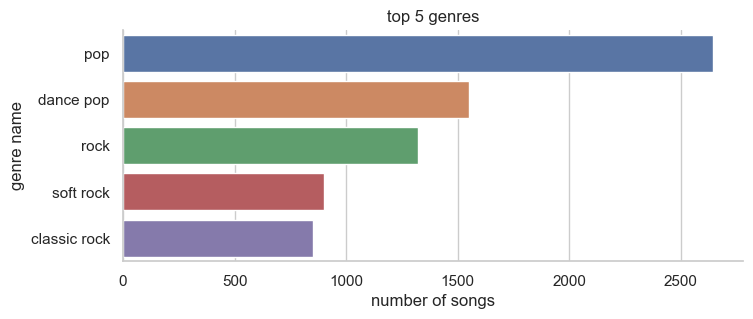

In [128]:
sns.barplot(data=Top5genre, x='number', y='genre')
plt.xlabel('number of songs')
plt.ylabel('genre name')
plt.title('top 5 genres')
sns.despine()

In [129]:
# На мировой сцене существенно преобладает поп-музыка, а также и рок, но значительно меньше. 
# Как можно заметить, эти два жанра имеют сравнительно низкий порог вхождения, что выводит их
# в топ-5.

#Пункт №6. Сопоставление уровней танцевальности, инструментальности и акустичности песен в зависимости 
от их популярности

In [130]:
start_int = [0, 40, 70]
end_int = [40, 70, 100]

dance_part = []
energy_part = []
acoustic_part = []
instrument_part = []
duration_part = []
period = []

for i in range(0, len(start_int)):
    df_part = Part_of_total(DF1, 'Popularity', start_int[i], end_int[i], 'DataFrame')
    dance_part.append(df_part['Danceability'].mean())
    energy_part.append(df_part['Energy'].mean())
    acoustic_part.append(df_part['Acousticness'].mean())
    instrument_part.append(df_part['Instrumentalness'].mean())
    duration_part.append(df_part['Track Duration (ms)'].mean())
    period.append(str(start_int[i]) + ' - ' + str(end_int[i]))

features_comp = pd.DataFrame({'Popularity':period, 'Danceability':dance_part,\
                               'Acousticness':acoustic_part, 'Instrumentalness':instrument_part, 'Duration':duration_part})

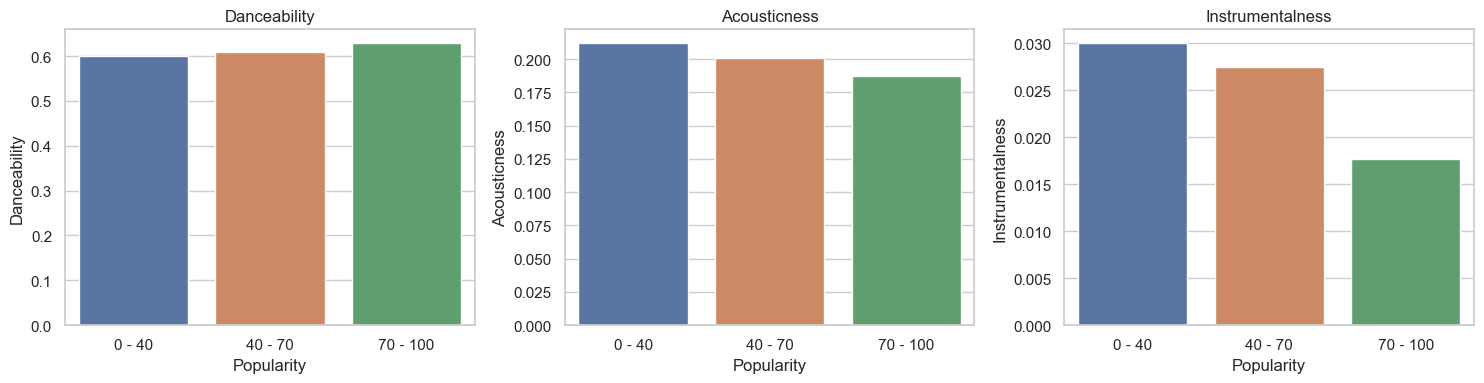

In [131]:
fig, axes = plt.subplots(1, 3, sharex=False, figsize=(15,4))
sns.barplot(ax=axes[0], data=features_comp, x='Popularity', y='Danceability')
ax = axes[0].set_title("Danceability")
sns.barplot(ax=axes[1], data=features_comp, x='Popularity', y='Acousticness')
ax = axes[1].set_title("Acousticness")
sns.barplot(ax=axes[2], data=features_comp, x='Popularity', y='Instrumentalness')
ax = axes[2].set_title("Instrumentalness")

plt.tight_layout()


In [132]:
# С большим добавлением электронного звучания в музыкальную композицию вырастает шанс приобретения высокой популярности
# песни. С течением времени у людей все больше возникает потребность в танцах под эту музыку, нежели в прослушивании
# чистого звучания музыкальных инструментов

#Пункт №7. Сортировка композиций по ключевым словам в жанрах и их анализ по основным параметрам.  

In [133]:
def evaluation_genre(Dataset, Column_dance, Column_energy, Column_instr, Column_acoustic, Column_duration):
    d = {Column_dance:0, Column_energy:0, Column_instr:0, Column_acoustic:0, Column_duration:0}
    d[Column_dance] = Dataset[Column_dance].mean()
    d[Column_energy] = Dataset[Column_energy].mean()
    d[Column_instr] = Dataset[Column_instr].mean()
    d[Column_acoustic] = Dataset[Column_acoustic].mean()
    d[Column_duration] = Dataset[Column_duration].mean()

    dd = pd.DataFrame(d.items(), columns=['parameter', 'mean_value'])

    return dd

In [134]:
search_words = ['pop', 'rock', 'rap', 'dance', 'hip hop']
danceability_list = []
energy_list = []
instr_list = []
acoustic_list = []
duration_list = []
for i in range(0, len(search_words)):

    DF = genre_searcher(DF1, 'Artist Genres', search_words[i])

    df = evaluation_genre(DF, 'Danceability', 'Energy', 'Instrumentalness', 'Acousticness', 'Track Duration (ms)')

    danceability_list.append(df['mean_value'].iloc[0])
    energy_list.append(df['mean_value'].iloc[1])
    instr_list.append(df['mean_value'].iloc[2])
    acoustic_list.append(df['mean_value'].iloc[3])
    duration_list.append(df['mean_value'].iloc[4])

genres_compar = pd.DataFrame({'genres':search_words,\
                              'danceability':danceability_list,\
                                'energy':energy_list,\
                                    'instrumentalness':instr_list,\
                                        'acousticness':acoustic_list,\
                                            'duration':duration_list})
genres_compar

,genres,danceability,energy,instrumentalness,acousticness,duration
0,pop,0.624277,0.696562,0.015845,0.186525,223537.256937
1,rock,0.557667,0.684139,0.028023,0.208641,231585.153472
2,rap,0.705373,0.726630,0.006036,0.118263,230207.117579
3,dance,0.661926,0.753824,0.028292,0.118393,227329.770235
4,hip hop,0.723943,0.721279,0.004090,0.118340,232362.655263


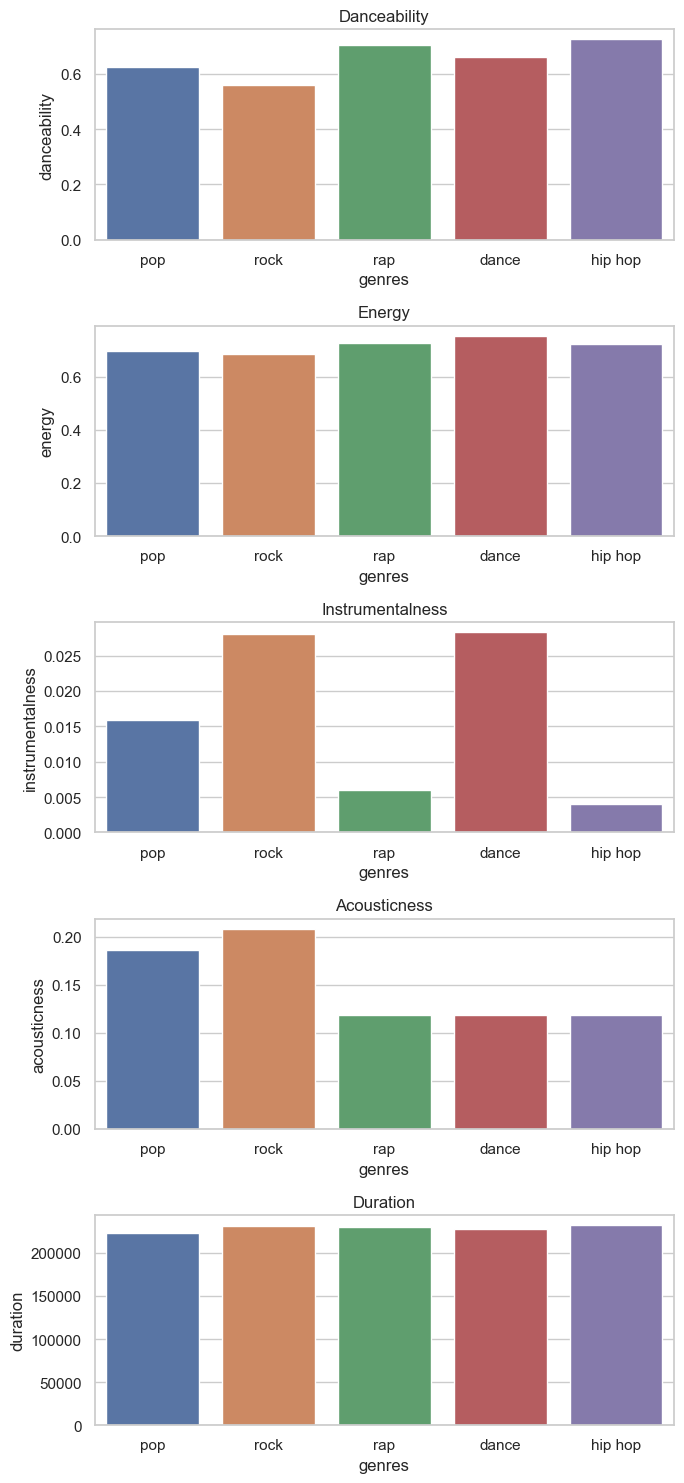

In [135]:
fig, axes = plt.subplots(5, 1, sharex=False, figsize=(7,15))
sns.barplot(ax=axes[0], data=genres_compar, x='genres', y='danceability')
ax = axes[0].set_title("Danceability")
sns.barplot(ax=axes[1], data=genres_compar, x='genres', y='energy')
ax = axes[1].set_title("Energy")
sns.barplot(ax=axes[2], data=genres_compar, x='genres', y='instrumentalness')
ax = axes[2].set_title("Instrumentalness")
sns.barplot(ax=axes[3], data=genres_compar, x='genres', y='acousticness')
ax = axes[3].set_title("Acousticness")
sns.barplot(ax=axes[4], data=genres_compar, x='genres', y='duration')
ax = axes[4].set_title("Duration")

plt.tight_layout()

#Пункт №8. Влияние времени релиза песни: день недели, месяц

In [136]:
DF1['Album Release Date'] = pd.to_datetime(DF1['Album Release Date'])
DayWeekRelease = DF1.groupby(DF1['Album Release Date'].dt.day_name())['Track Name'].count().to_frame('number of releases').reset_index()\
    .sort_values('number of releases', ascending=False).rename(columns={'Album Release Date':'Day of the week'})

In [137]:
DF1['Album Release Date'] = pd.to_datetime(DF1['Album Release Date'])
MonthRelease = DF1.groupby(DF1['Album Release Date'].dt.month_name())['Track Name'].count().to_frame('number of releases').reset_index().\
    sort_values('number of releases', ascending=False).rename(columns={'Album Release Date':'Month of release'})

In [138]:
day_of_the_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
popularity_list = []
for i in range(0, len(day_of_the_week)):
    df_week = DF1.loc[DF1['Album Release Date'].dt.day_name()==day_of_the_week[i]]
    popularity_list.append(df_week['Popularity'].mean())

day_week_parameters = pd.DataFrame({'Day of the week':day_of_the_week, 'Popularity':popularity_list})
dw = day_week_parameters.sort_values('Popularity', ascending=False)

info_day_week = DayWeekRelease.merge(dw, on='Day of the week', how='inner')
info_day_week


,Day of the week,number of releases,Popularity
0,Friday,2947,39.968442
1,Tuesday,1823,40.185957
2,Monday,1702,38.579906
3,Thursday,891,38.792368
4,Saturday,758,33.912929
5,Wednesday,741,37.230769
6,Sunday,567,34.123457


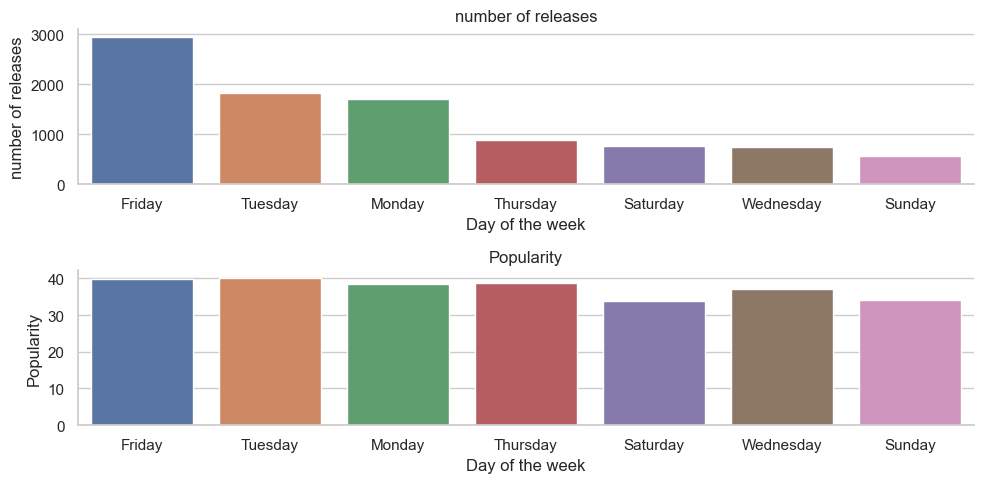

In [139]:
fig, axes = plt.subplots(2, 1, sharex=False, figsize=(10,5))
sns.barplot(ax=axes[0], data=info_day_week, x='Day of the week', y='number of releases')
ax = axes[0].set_title("number of releases")
sns.barplot(ax=axes[1], data=info_day_week, x='Day of the week', y='Popularity')
ax = axes[1].set_title("Popularity")
plt.tight_layout()
sns.despine()

In [140]:
months = ['January', 'February', 'March', 'April', 'May',\
          'June', 'July', 'August', 'September', 'October',\
            'November', 'December']

popularity_list_month = []

for i in range(0, len(months)):
    df_month = DF1.loc[DF1['Album Release Date'].dt.month_name()==months[i]]
    popularity_list_month.append(df_month['Popularity'].mean())

month_parameters = pd.DataFrame({'Month of release':months, 'Popularity':popularity_list_month})
dm = month_parameters.sort_values('Popularity', ascending=False)

info_month = MonthRelease.merge(dm, on='Month of release', how='inner')
info_month

,Month of release,number of releases,Popularity
0,January,3290,33.562918
1,November,860,40.173256
2,October,842,39.858670
3,September,675,41.622222
4,March,594,41.797980
5,June,586,42.493174
6,May,531,42.318267
7,July,459,39.745098
8,April,441,42.460317
9,August,434,38.695853


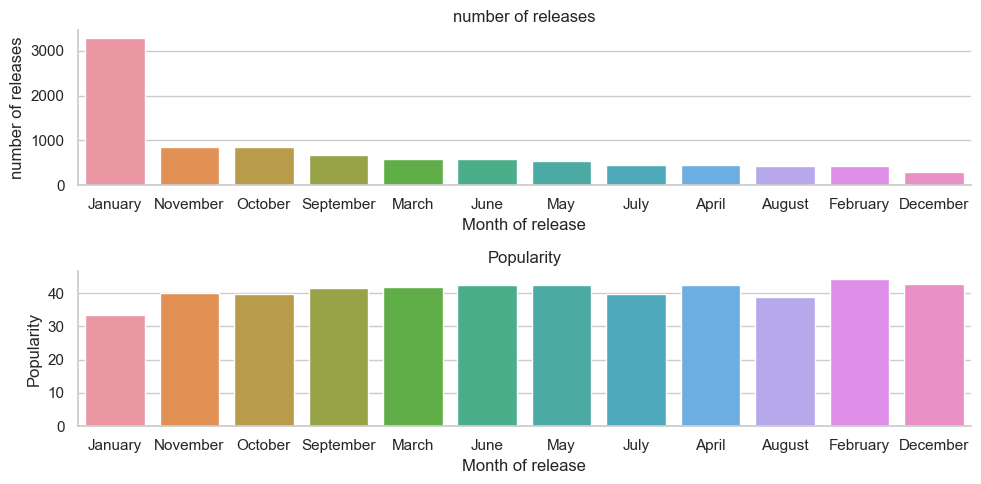

In [141]:
fig, axes = plt.subplots(2, 1, sharex=False, figsize=(10,5))
sns.barplot(ax=axes[0], data=info_month, x='Month of release', y='number of releases')
ax = axes[0].set_title("number of releases")
sns.barplot(ax=axes[1], data=info_month, x='Month of release', y='Popularity')
ax = axes[1].set_title("Popularity")
plt.tight_layout()
sns.despine()

In [142]:
# Наиболее часто релиз песни происходит в пятницу, реже всего - в воскресенье. Однако наибольшая средняя популярность
# наблюдается у песен, выпущенных по вторник.
# Также важно отметить, что чаще всего выпуск песен производится в Январе. Но самая высокая популярность присуща песням с Февраля и Декабря.

#Пункт №9. Вывод плейлиста из 10 треков на основе предпочтений

In [143]:
def playlist(Dataset, Current_mood, Genre, Start_period, End_period):
    Dataset['Album Release Date'] = pd.to_datetime(Dataset['Album Release Date'])
    
    if Current_mood == 'Fun' or Current_mood == 'Smile':
        ds = genre_searcher(Dataset, 'Artist Genres', Genre)
        dss = ds.loc[(ds['Album Release Date'].dt.year <= End_period) &  (ds['Album Release Date'].dt.year >= Start_period)]
        dss = dss.loc[(dss['Danceability']>=0.6) & (dss['Danceability']<=0.98)]
        dss = dss.loc[(dss['Energy']>=0.6) & (dss['Energy']<=0.98)]
        dss['song name'] = dss['Artist Name(s)'].astype(str) + ' - ' + dss['Track Name'].astype(str)
        return list(dss['song name'].sample(n=10).unique())
    
    elif Current_mood == 'Sad' or Current_mood == 'Depressed':
        ds = genre_searcher(Dataset, 'Artist Genres', Genre)
        dss = ds.loc[(ds['Album Release Date'].dt.year <= End_period) &  (ds['Album Release Date'].dt.year >= Start_period)]
        dss = dss.loc[(dss['Danceability']<=0.6) & (dss['Danceability']>=0.1)]
        dss = dss.loc[(dss['Instrumentalness']<=0.8) & (dss['Instrumentalness']>=0.1)]
        dss['song name'] = dss['Artist Name(s)'].astype(str) + ' - ' + dss['Track Name'].astype(str)
        return list(dss['song name'].sample(n=10).unique())
    
    elif Current_mood == 'Tired' or Current_mood == 'Sleepy':
        ds = genre_searcher(Dataset, 'Artist Genres', Genre)
        dss = ds.loc[(ds['Album Release Date'].dt.year <= End_period) &  (ds['Album Release Date'].dt.year >= Start_period)]
        dss = dss.loc[(dss['Danceability']<=0.3) & (dss['Danceability']>=0.1)]
        dss = dss.loc[(dss['Instrumentalness']<=0.8) & (dss['Instrumentalness']>=0.1)]
        dss = dss.loc[(dss['Energy']>=0.3) & (dss['Danceability']<=0.01)]
        dss['song name'] = dss['Artist Name(s)'].astype(str) + ' - ' + dss['Track Name'].astype(str)
        return list(dss['song name'].sample(n=10).unique())
    
    elif Current_mood == 'Sport' or Current_mood == 'Energetic':
        ds = genre_searcher(Dataset, 'Artist Genres', Genre)
        dss = ds.loc[(ds['Album Release Date'].dt.year <= End_period) & (ds['Album Release Date'].dt.year >= Start_period)]
        dss = dss.loc[(dss['Danceability']<=0.98) & (dss['Danceability']>=0.75)]
        dss = dss.loc[(dss['Energy']>=0.7) & (dss['Danceability']<=0.99)]
        dss['song name'] = dss['Artist Name(s)'].astype(str) + ' - ' + dss['Track Name'].astype(str)
        return list(dss['song name'].sample(n=10).unique())
    
    elif Current_mood == 'Drunk' or Current_mood == 'Party':
        ds = genre_searcher(Dataset, 'Artist Genres', Genre)
        dss = ds.loc[(ds['Album Release Date'].dt.year <= End_period) & (ds['Album Release Date'].dt.year >= Start_period)]
        dss = dss.loc[(dss['Danceability']<=0.98) & (dss['Danceability']>=0.5)]
        dss = dss.loc[(dss['Energy']>=0.4) & (dss['Danceability']<=0.99)]
        dss = dss.loc[(dss['Instrumentalness']<=0.8) & (dss['Instrumentalness']>=0.1)]
        dss['song name'] = dss['Artist Name(s)'].astype(str) + ' - ' + dss['Track Name'].astype(str)
        return list(dss['song name'].sample(n=10).unique())


In [144]:
# Представляется возможность получить плейлист на основе Ваших предпочтений.
# Необходимо узнать Ваше текущее настроение, любимый жанр и временной диапазон (годы), в который войдут песни для Вас.
# Массив, на основе которого идет составление списка, имеет название DF1.
playlist(DF1, 'Fun', 'rock', 2011, 2023)

['Cutting Crew - (I Just) Died in Your Arms',
 'INXS - Original Sin',
 'Imagine Dragons - Believer',
 'Phillip Phillips - Gone, Gone, Gone',
 'Roy Orbison - California Blue',
 'Mondo Rock - State Of The Heart - Digitally Remastered',
 'Fitz and The Tantrums - HandClap',
 "Chicane, Bryan Adams - Don't Give Up",
 'Train - Drive By']